# Inference with Segment-NT models

[![Open All Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/instadeepai/nucleotide-transformer/blob/main/examples/inference_segment_nt.ipynb)

## Installation and imports

In [1]:
!pip install boto3
!pip install matplotlib
!pip install biopython
!pip install dm-haiku

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.2/82.2 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 371.7/371.7 kB 2.9 MB/s eta 0:00:00


In [2]:
import os

try:
    import nucleotide_transformer
except:
    !pip install git+https://github.com/instadeepai/nucleotide-transformer@main |tail -n 1
    import nucleotide_transformer

if "COLAB_TPU_ADDR" in os.environ:
    from jax.tools import colab_tpu

    colab_tpu.setup_tpu()

  Running command git clone --filter=blob:none --quiet https://github.com/instadeepai/nucleotide-transformer /tmp/pip-req-build-6s1ybyxy


In [3]:
from Bio import SeqIO
import gzip
import haiku as hk
import jax
import jax.numpy as jnp
import numpy as np
import seaborn as sns
from typing import List
import matplotlib.pyplot as plt
from nucleotide_transformer.pretrained import get_pretrained_segment_nt_model

jax.config.update("jax_platform_name", "cpu")

backend = "gpu"
devices = jax.devices(backend)
num_devices = len(devices)
print(f"Devices found: {devices}")

Devices found: [cuda(id=0)]


# Define function that plots the probabilities

In [4]:
# seaborn settings
sns.set_style("whitegrid")
sns.set_context(
    "notebook",
    font_scale=1,
    rc={
        "font.size": 14,
        "axes.titlesize": 18,
        "axes.labelsize": 18,
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "legend.fontsize": 16,
        }
)

plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

# set colors
colors = sns.color_palette("Set2").as_hex()
colors2 = sns.color_palette("husl").as_hex()

# Rearrange order of the features to match Fig.3 from the paper.
features_rearranged = [
 'protein_coding_gene',
 'lncRNA',
 '5UTR',
 '3UTR',
 'exon',
 'intron',
 'splice_donor',
 'splice_acceptor',
 'promoter_Tissue_specific',
 'promoter_Tissue_invariant',
 'enhancer_Tissue_specific',
 'enhancer_Tissue_invariant',
 'CTCF-bound',
 'polyA_signal',
]

def plot_features(
    predicted_probabilities_all,
    seq_length: int,
    features: List[str],
    order_to_plot: List[str],
    fig_width=8,
):
    """
    Function to plot labels and predicted probabilities.

    Args:
        predicted_probabilities_all: Probabilities per genomic feature for each
            nucleotides in the DNA sequence.
        seq_length: DNA sequence length.
        feature: Genomic features to plot.
        order_to_plot: Order in which to plot the genomic features. This needs to be
            specified in order to match the order presented in the Fig.3 of the paper
        fig_width: Width of the figure
    """

    sc = 1.8
    n_panels = 7

    # fig, axes = plt.subplots(n_panels, 1, figsize=(fig_width * sc, (n_panels + 2) * sc), height_ratios=[6] + [2] * (n_panels-1))
    _, axes = plt.subplots(n_panels, 1, figsize=(fig_width * sc, (n_panels + 4) * sc))

    for n, feat in enumerate(order_to_plot):
        feat_id = features.index(feat)
        prob_dist = predicted_probabilities_all[:, feat_id]

        # Use the appropriate subplot
        ax = axes[n // 2]

        try:
            id_color = colors[feat_id]
        except:
            id_color = colors2[feat_id - 8]
        ax.plot(
            prob_dist,
            color=id_color,
            label=feat,
            linestyle="-",
            linewidth=1.5,
        )
        ax.set_xlim(0, seq_length)
        ax.grid(False)
        ax.spines['bottom'].set_color('black')
        ax.spines['top'].set_color('black')
        ax.spines['right'].set_color('black')
        ax.spines['left'].set_color('black')

    for a in range (0,n_panels):
        axes[a].set_ylim(0, 1.05)
        axes[a].set_ylabel("Prob.")
        axes[a].legend(loc="upper left", bbox_to_anchor=(1, 1), borderaxespad=0)
        if a != (n_panels-1):
            axes[a].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)

    # Set common x-axis label
    axes[-1].set_xlabel("Nucleotides")
    # axes[0].axis('off')  # Turn off the axis
    axes[n_panels-1].grid(False)
    axes[n_panels-1].tick_params(axis='y', which='both', left=True, right=False, labelleft=True, labelright=False)

    axes[0].set_title("Probabilities predicted over all genomics features", fontweight="bold")

    plt.show()


# Get human chromosome 20

To reproduce the figures of the Segment-NT paper, we retrieve here the file of the
human chromosome 20

### Download fasta file of chromosome 20 of the human genome

In [5]:
! wget https://ftp.ensembl.org/pub/release-111/fasta/homo_sapiens/dna/Homo_sapiens.GRCh38.dna.chromosome.20.fa.gz

--2024-03-28 15:58:01--  https://ftp.ensembl.org/pub/release-111/fasta/homo_sapiens/dna/Homo_sapiens.GRCh38.dna.chromosome.20.fa.gz
Resolving ftp.ensembl.org (ftp.ensembl.org)... 193.62.193.169
Connecting to ftp.ensembl.org (ftp.ensembl.org)|193.62.193.169|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18833053 (18M) [application/x-gzip]
Saving to: ‘Homo_sapiens.GRCh38.dna.chromosome.20.fa.gz’

Homo_sapiens.GRCh38 100%[===================>]  17.96M   653KB/s    in 28s     

2024-03-28 15:58:30 (649 KB/s) - ‘Homo_sapiens.GRCh38.dna.chromosome.20.fa.gz’ saved [18833053/18833053]



In [6]:
fasta_path = "Homo_sapiens.GRCh38.dna.chromosome.20.fa.gz"

with gzip.open(fasta_path, "rt") as handle:
    record = next(SeqIO.parse(handle, "fasta"))
    chr20 = str(record.seq)

# Infer on 10kb genomic sequence (Does not require changing the rescaling factor in the forward function)

## Instantiate SegmentNT inference function
The following cell allows you to download the weights of one of the Segment-NT models. It returns the weights dictionary, the haiku forward function, the tokenizer and the config dictionary.

Just like for the `get_pretrained_nucleotide_transformer` function, you can also specify:
1. the layers at which you'd like to collect embeddings (e.g. (5, 10, 20) to get embeddings at layers 5, 10 and 20)
2. the attention maps you´d like to collect (e.g. ((1,4), (7,18)) to get attention maps corresponding to layer 1 head number 4 and layer 7 head number 18). Please refer to the config to see the number of layers and heads in the model.
3. the maximum number of tokens in the sequences you'll compute the inference on. You can put values up to value specified in the model's config (counting the class token that will be added automatically at the beginning of the sequence), however we recommend keeping this number as small as possible for optimized memory and inference time.

In [7]:
# The number of DNA tokens (excluding the CLS token prepended) needs to be dividible by
# the square of the number of downsampling block, i.e 4.
max_num_nucleotides = 1668

assert max_num_nucleotides % 4 == 0, (
    "The number of DNA tokens (excluding the CLS token prepended) needs to be dividible by"
     "2 to the power of the number of downsampling block, i.e 4.")

# If max_num_nucleotides is larger than what was used to train Segment-NT, the rescaling
# factor needs to be adapted.
if max_num_nucleotides + 1 > 5001:
    inference_rescaling_factor = (max_num_nucleotides + 1) / 2048
else:
    inference_rescaling_factor=None

# If this download fails at one point, restarting it will not work.
# Before rerunning the cell, make sure to delete the cache by executing:
# ! rm -rf ~/.cache/nucleotide_transformer/
parameters, forward_fn, tokenizer, config = get_pretrained_segment_nt_model(
    model_name="segment_nt",
    rescaling_factor=inference_rescaling_factor,
    embeddings_layers_to_save=(29,),
    attention_maps_to_save=((1, 4), (7, 10)),
    max_positions=max_num_nucleotides + 1,
)
forward_fn = hk.transform(forward_fn)
apply_fn = jax.pmap(forward_fn.apply, devices=devices, donate_argnums=(0,))

# Put required quantities for the inference on the devices. This step is not
# reproduced in the second inference since the quantities will already be loaded
# on the devices !
random_key = jax.random.PRNGKey(seed=0)
keys = jax.device_put_replicated(random_key, devices=devices)
parameters = jax.device_put_replicated(parameters, devices=devices)

checkpoints/segment_nt/hyperparams.json


/root/.cache/nucleotide_transformer/segment_nt/hyperparams.json: 100%|██████████| 1.09k/1.09k [00:00<00:00, 4.44kB/s]
/root/.cache/nucleotide_transformer/segment_nt/ckpt.joblib: 100%|██████████| 2.25G/2.25G [00:38<00:00, 59.0MB/s]


## Tokenize the DNA sequence

In [8]:
idx_start = 2650520

idx_stop = idx_start + max_num_nucleotides*6

sequences = [chr20[idx_start:idx_stop]]
tokens_ids = [b[1] for b in tokenizer.batch_tokenize(sequences)]
tokens_str = [b[0] for b in tokenizer.batch_tokenize(sequences)]

# This stacks the batch so that it is repeated across the devices. This is done
# in order to allow for replication even if one has more than one device.
# To take advantage of the multiple devices and infer different sequences on
# each of the devices, make sure to change this line into a reshape.
# a reshape
tokens = jnp.stack([jnp.asarray(tokens_ids, dtype=jnp.int32)]*num_devices, axis=0)
tokens.shape


(1, 1, 1669)

## Infer on the resulting batch

In [9]:
# Infer
outs = apply_fn(parameters, keys, tokens)

# Obtain the logits over the genomic features
logits = outs["logits"]
# Transform them on probabilities
probabilities = np.asarray(jax.nn.softmax(logits, axis=-1))[...,-1]

/usr/local/lib/python3.10/dist-packages/jax/_src/interpreters/mlir.py:790: UserWarning: Some donated buffers were not usable: ShapedArray(float32[1024,8192]), ShapedArray(float32[4096,1024]), ShapedArray(float32[1024]), ShapedArray(float32[1024]), ShapedArray(float32[1024]), ShapedArray(float32[1024,1024]), ShapedArray(float32[1024]), ShapedArray(float32[1024,1024]), ShapedArray(float32[1024]), ShapedArray(float32[1024,1024]), ShapedArray(float32[1024]), ShapedArray(float32[1024,1024]), ShapedArray(float32[1024]), ShapedArray(float32[1024]), ShapedArray(float32[1024,8192]), ShapedArray(float32[4096,1024]), ShapedArray(float32[1024]), ShapedArray(float32[1024]), ShapedArray(float32[1024]), ShapedArray(float32[1024,1024]), ShapedArray(float32[1024]), ShapedArray(float32[1024,1024]), ShapedArray(float32[1024]), ShapedArray(float32[1024,1024]), ShapedArray(float32[1024]), ShapedArray(float32[1024,1024]), ShapedArray(float32[1024]), ShapedArray(float32[1024]), ShapedArray(float32[1024,8192]

In [10]:
probabilities.shape

(1, 1, 10008, 14)

## Plot the probabilities for 14 genomic features along this DNA sequence

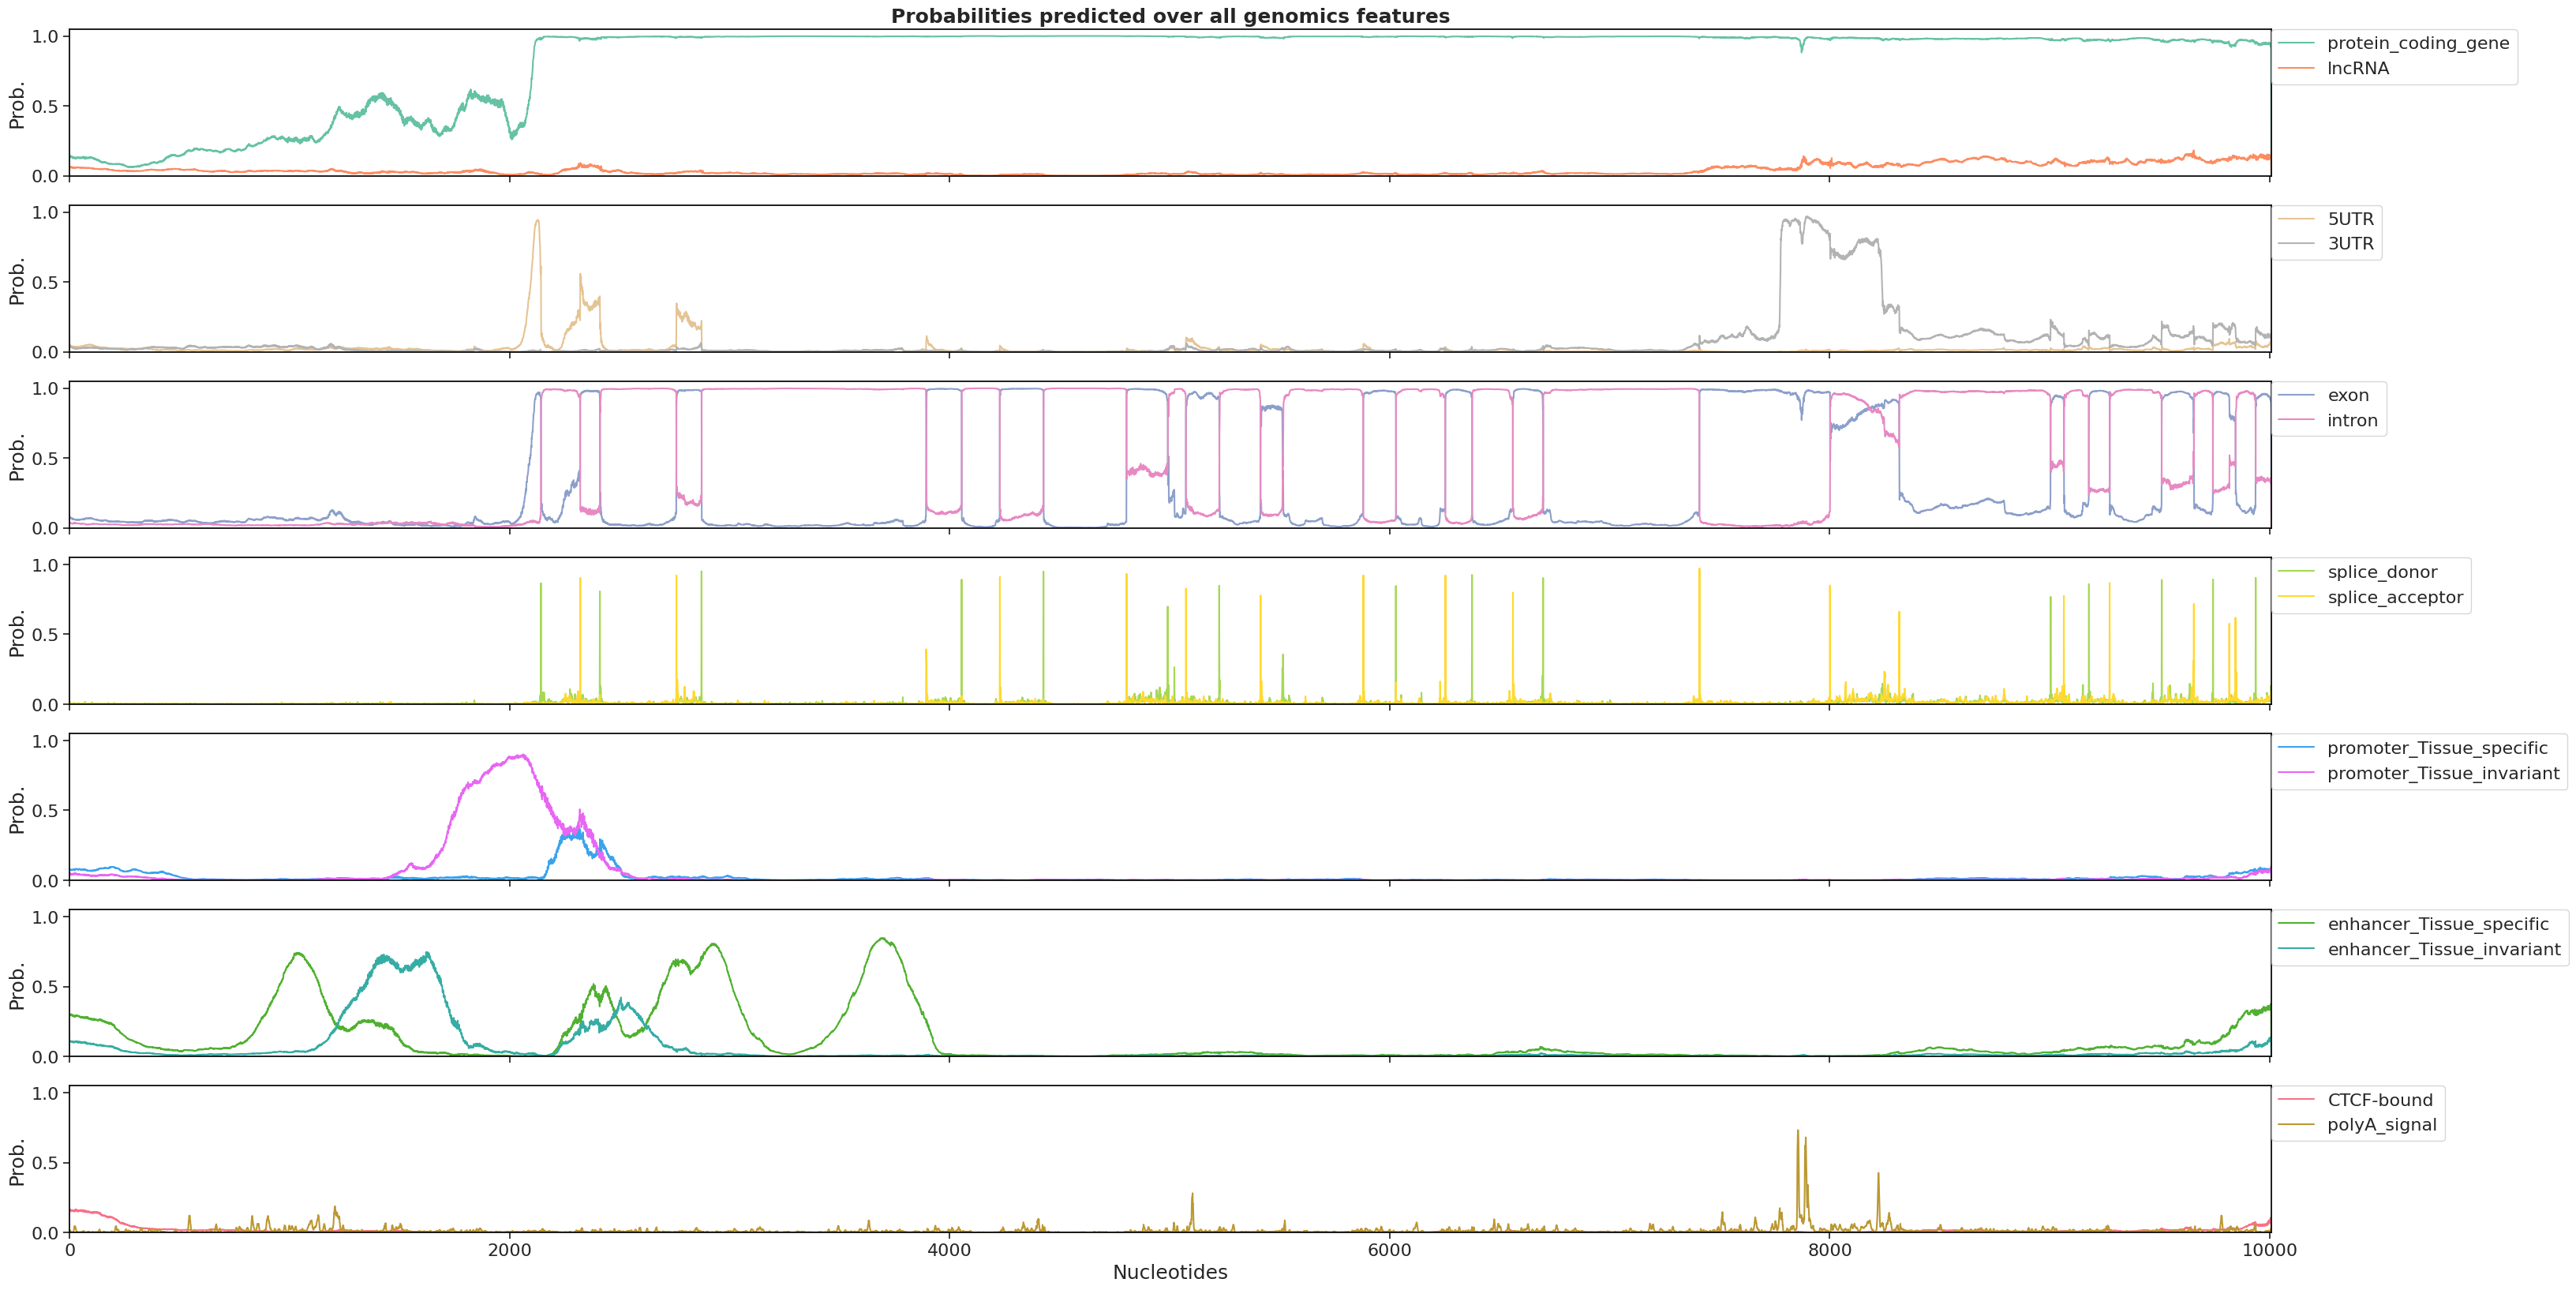

In [11]:
plot_features(
    probabilities[0,0],
    probabilities.shape[-2],
    fig_width=20,
    features=config.features,
    order_to_plot=features_rearranged
)

# Infer and plot on 50kb genomic sequence (Requires changing the rescaling factor in the forward function)

## Instantiate SegmentNT inference function

In [12]:
# The number of DNA tokens (excluding the CLS token prepended) needs to be dividible by
# the square of the number of downsampling block, i.e 4.
max_num_nucleotides = 8332

assert max_num_nucleotides % 4 == 0, (
    "The number of DNA tokens (excluding the CLS token prepended) needs to be dividible by"
     "2 to the power of the number of downsampling block, i.e 4.")

# If max_num_nucleotides is larger than what was used to train Segment-NT, the rescaling
# factor needs to be adapted.
if max_num_nucleotides + 1 > 5001:
    inference_rescaling_factor = (max_num_nucleotides + 1) / 2048
else:
    inference_rescaling_factor=None

# The parameters have already been downloaded above
# so we do not instantiate them. However we instantiate a new forward function
# where the context length extension needed is in effect.
_, forward_fn, tokenizer, config = get_pretrained_segment_nt_model(
    model_name="segment_nt",
    rescaling_factor=inference_rescaling_factor,
    embeddings_layers_to_save=(29,),
    attention_maps_to_save=((1, 4), (7, 10)),
    max_positions=max_num_nucleotides + 1,
)
forward_fn = hk.transform(forward_fn)
apply_fn = jax.pmap(forward_fn.apply, devices=devices, donate_argnums=(0,))

## Tokenize the DNA sequence

In [13]:
idx_start = 5100000
idx_stop = idx_start + max_num_nucleotides*6

sequences = [chr20[idx_start:idx_stop]]
tokens_ids = [b[1] for b in tokenizer.batch_tokenize(sequences)]
tokens_str = [b[0] for b in tokenizer.batch_tokenize(sequences)]

# This stacks the batch so that it is repeated across the devices. This is done
# in order to allow for replication even if one has more than one device.
# To take advantage of the multiple devices and infer different sequences on
# each of the devices, make sure to change this line into a reshape.
# a reshape
tokens = jnp.asarray(tokens_ids, dtype=jnp.int32)[None, :]
tokens.shape


(1, 1, 8333)

## Infer on the resulting batch

In [14]:
# Infer
outs = apply_fn(parameters, keys, tokens)

# Obtain the logits over the genomic features
logits = outs["logits"]
# Transform them on probabilities
probabilities = np.asarray(jax.nn.softmax(logits, axis=-1))[...,-1]

## Plot the probabilities for 14 genomic features along this DNA sequence

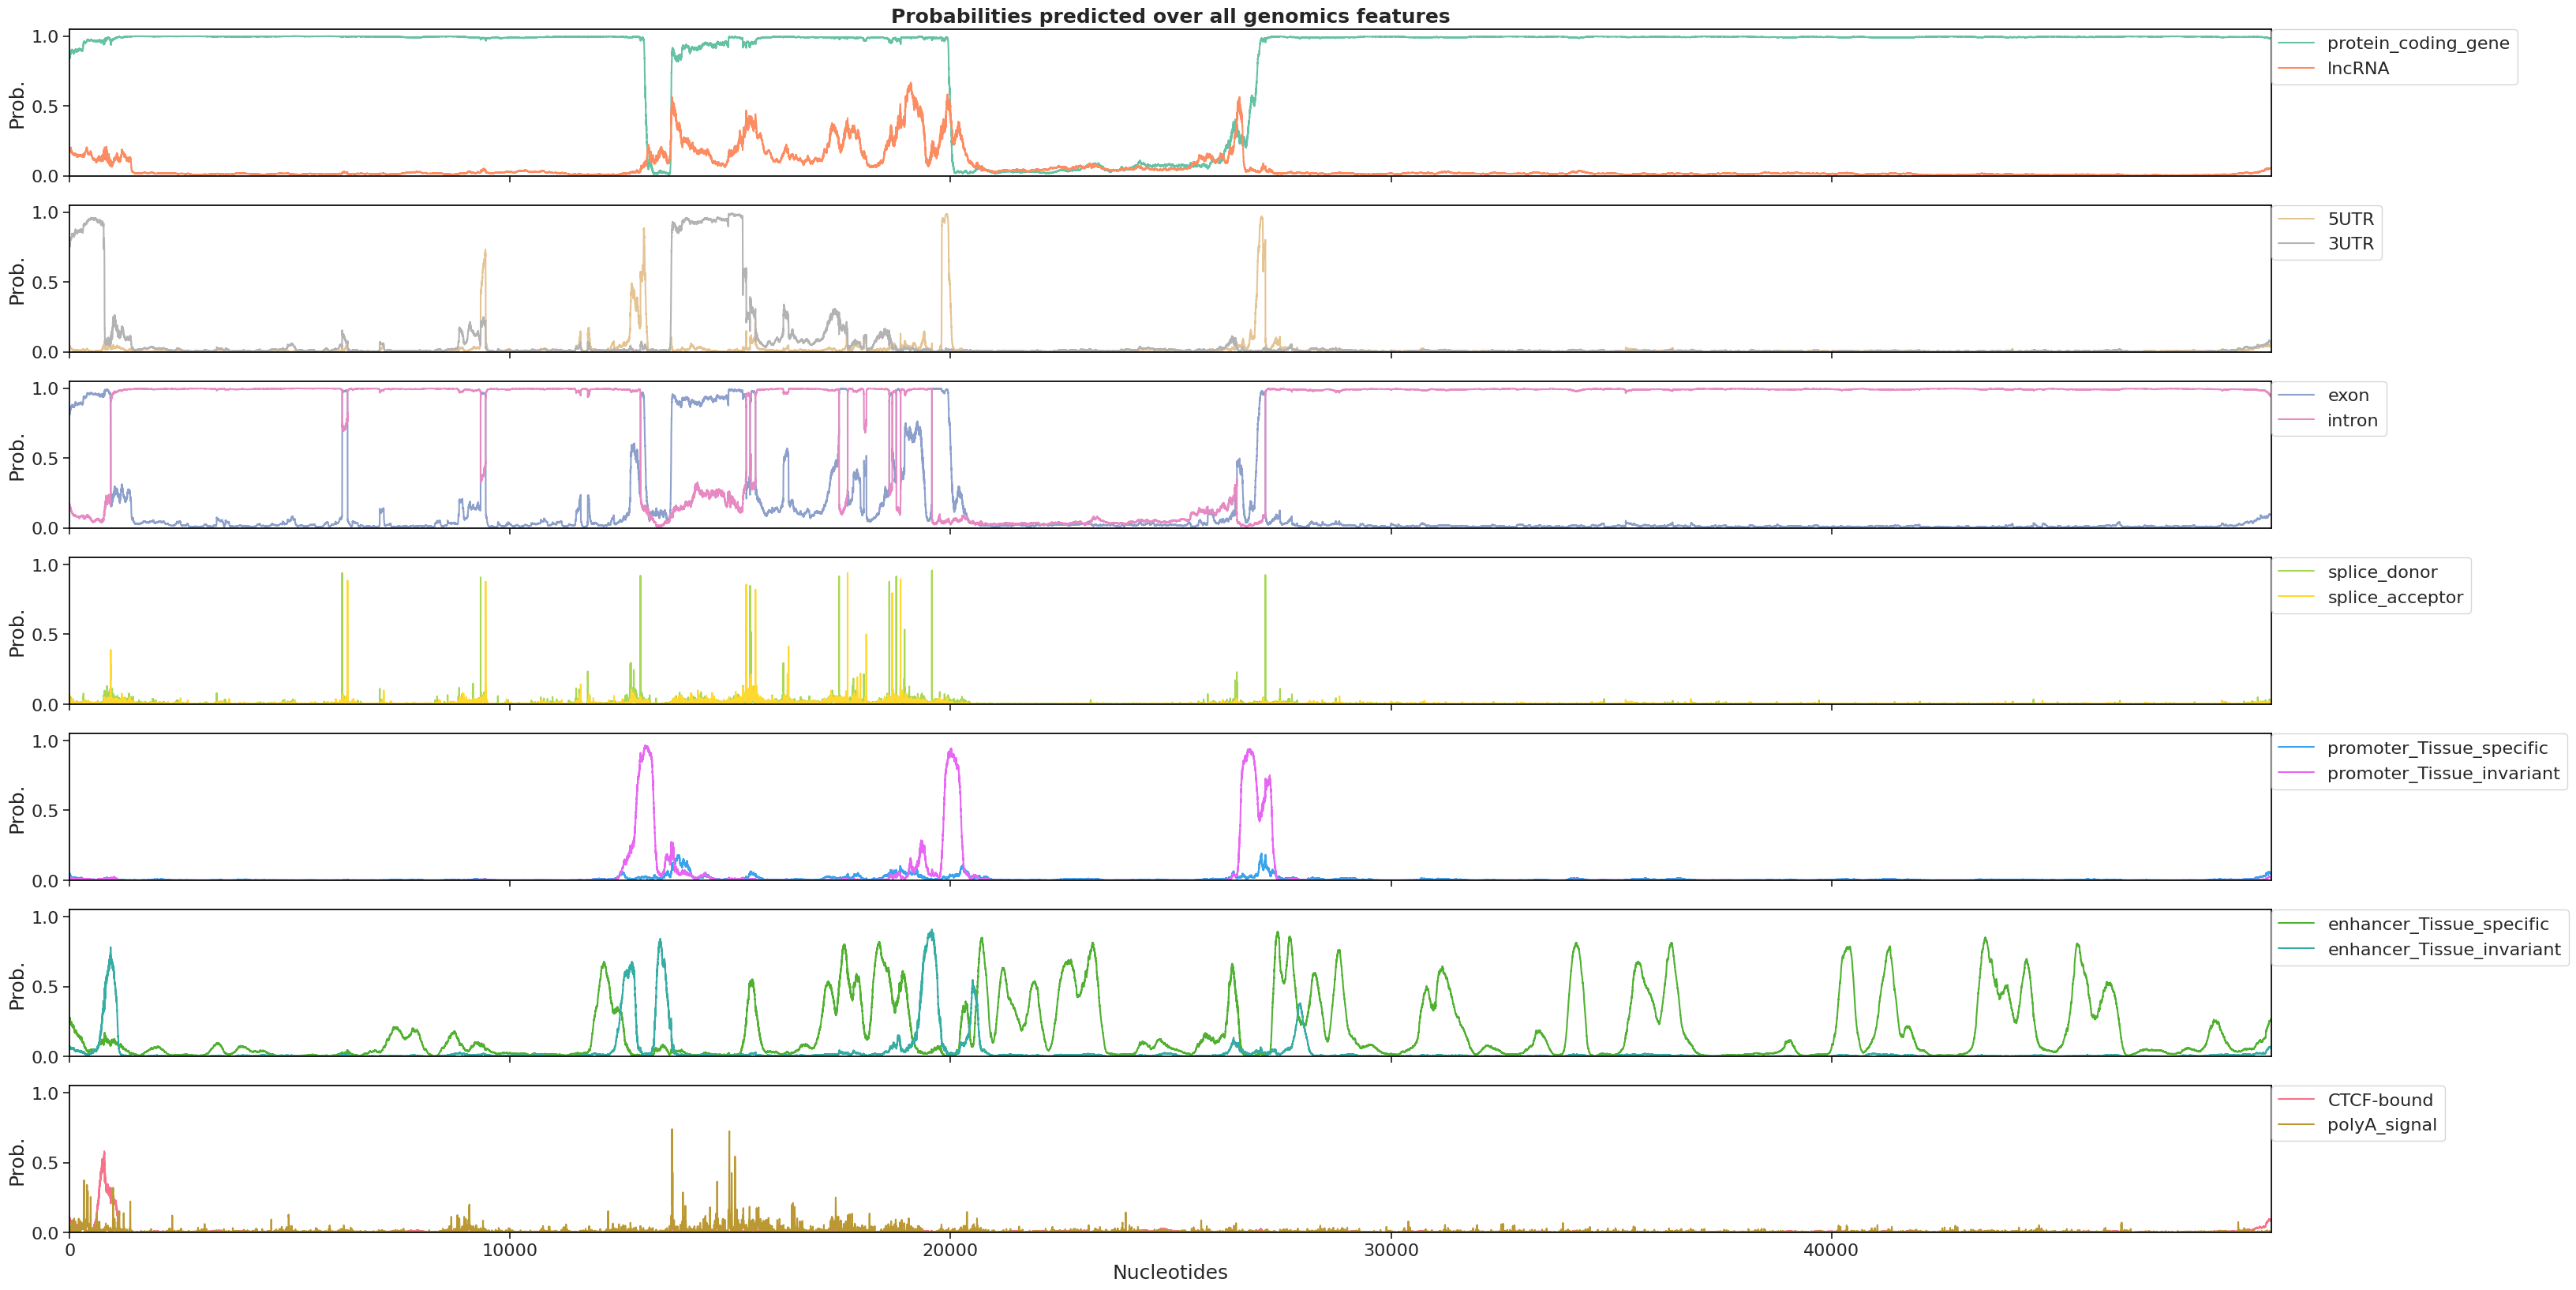

In [15]:
plot_features(
    probabilities[0,0],
    probabilities.shape[-2],
    fig_width=20,
    features=config.features,
    order_to_plot=features_rearranged
)